## WFC3 Guide Star Failure Classification Using Convolutional Neural Networks (CNNs)
---
The purpose of this notebook is to demosnstrate how to use a DeepWFC3 machine learning model to identify if a WFC3 image is affected by a guide star failure (GS fail). The models presented here are fully described in the WFC3-ISR-2024-xx


In [66]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations
from ginga.util.zscale import zscale

# Machine Learning modules:
import torch
from torch import nn

# Data processing and augmentation module:
import data_process

## Download Example Data



We will start by downloading some sample images from the MAST database, using astroquery, that are examples of nominal and GS fail images.

The rootnames of the guide star failures are:
- ied203fqq
- ie9m0xv1q
- ieou18fkq

The nominal images are:
- iec39axmq
- ientf1gjq
- ie3b36n5q
- ie3b40ljq

First we will get a table of the fits files with the image data that we are interested in to make sure that we are downloading the correct files:

In [2]:
# IDs and rootnames of the example images we'll download
example_IDs = ['ied203*', 'ie9m0x020', 'ieou18020','iec39a010', 'ientf1010', 'ie3b36010', 'ie3b40010']
rootnames = ['ied203fqq', 'ie9m0xv1q', 'ieou18fkq', 'iec39axmq', 'ientf1gjq', 'ie3b36n5q', 'ie3b40ljq']

example_query = Observations.query_criteria(obs_id = example_IDs )
example_prods = Observations.get_product_list(example_query)
example_table = Observations.filter_products(example_prods, obs_id = rootnames, extension=['_flt.fits'])
example_table

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str37,str64,str1,str69,str9,str28,str11,str1,str7,str19,str5,str52,int64,str8,str6,int64
60922088,HST,image,ied203fqq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ied203fqq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),16200,ied203fqq_flt.fits,10730880,60922444,PUBLIC,2
62339763,HST,image,ie3b40ljq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ie3b40ljq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),15900,ie3b40ljq_flt.fits,2862720,62339793,PUBLIC,2
62345053,HST,image,ie9m0xv1q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ie9m0xv1q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),15891,ie9m0xv1q_flt.fits,168675840,62345099,PUBLIC,2
62345777,HST,image,ie3b36n5q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ie3b36n5q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),15900,ie3b36n5q_flt.fits,2862720,62345830,PUBLIC,2
64268407,HST,image,iec39axmq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/iec39axmq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),16302,iec39axmq_flt.fits,2862720,64268437,PUBLIC,2
71739051,HST,image,ientf1gjq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ientf1gjq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),16651,ientf1gjq_flt.fits,2862720,71739058,PUBLIC,2
75023931,HST,image,ieou18fkq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ieou18fkq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),16667,ieou18fkq_flt.fits,168439680,75189741,PUBLIC,2


Once we have confirmed that the files in the table are the correct images, and that the correct number of them are in the table (7), we download them from MAST:

In [3]:
# Download the images we want to use:
downloads = Observations.download_products(example_table, mrp_only=False, cache=False)

downloads

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ied203fqq/ied203fqq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ie3b40ljq/ie3b40ljq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ie9m0xv1q/ie9m0xv1q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ie3b36n5q/ie3b36n5q_flt.fits,COMPLETE,None,None
./mastDownload/HST/iec39axmq/iec39axmq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ientf1gjq/ientf1gjq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ieou18fkq/ieou18fkq_flt.fits,COMPLETE,None,None


In [5]:
downloads['Local Path']

./mastDownload/HST/ied203fqq/ied203fqq_flt.fits
./mastDownload/HST/ie3b40ljq/ie3b40ljq_flt.fits
./mastDownload/HST/ie9m0xv1q/ie9m0xv1q_flt.fits
./mastDownload/HST/ie3b36n5q/ie3b36n5q_flt.fits
./mastDownload/HST/iec39axmq/iec39axmq_flt.fits
./mastDownload/HST/ientf1gjq/ientf1gjq_flt.fits
./mastDownload/HST/ieou18fkq/ieou18fkq_flt.fits


## Process and augment the images:

Next, we will use the data_process module to process and augment the example images that we just downloaded. The function log_data_process will do the following:
* Opens the SCI array of the flt file, and creates an array of image data.
* Sets all values in the image array that are less than one to be equal to 1.
* Scales the image data logarithmically.
* Resizes the image array to the dimensions (256, 256).
* Uses min/max scaling to scale the pixel values to be between 0 and 1.

The augment function will create an augmented copy of the processed image by:
* Vertically flipping the image with a 50% probability.
* Horizontally flipping the image with a 50% probability.
* Rotating the image to a random degree of (0,360].
* Cropping the image in the center to be (180,180).

In [69]:
# initialize lists of images and rootnames
original_images = []
processed_images = []
augmented_images = []
root = []

# Process the images
for i in range(0,len(downloads['Local Path'])):
    # Get the processed and original version of the image
    proc_image, orig_image = data_process.log_image_process(downloads['Local Path'][i], True)
    processed_images.append(proc_image)
    original_images.append(orig_image)
    
    # Get an augmented version of the image
    aug_image = data_process.augment(proc_image)
    augmented_images.append(aug_image)
    
    # get ordered list of rootnames for later
    base = os.path.basename(downloads['Local Path'][i])
    root.append(base.split('_')[0])

# convert to arrays
proc_examples = np.array(processed_images)
aug_examples = np.array(augmented_images)

['ied203fqq',
 'ie3b40ljq',
 'ie9m0xv1q',
 'ie3b36n5q',
 'iec39axmq',
 'ientf1gjq',
 'ieou18fkq']

Now that we have the processed and augmented images we can look at the difference between the original, processed, and augmented images:

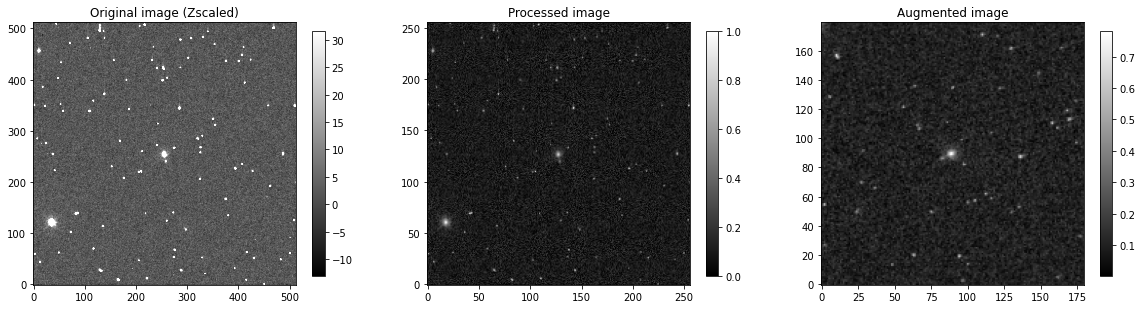

In [77]:
# Change the number to look at different images in the set
img = 1
vmin,vmax = zscale(original_images[img])

fig, axs = plt.subplots(1,3, figsize=[20,30])
# Plot the unprocessed image
axs[0].set_title('Original image (Zscaled)')
A = axs[0].imshow(original_images[img],vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
fig.colorbar(A, ax=axs[0],shrink=0.15)
# Plot the processed image
axs[1].set_title('Processed image')
B = axs[1].imshow(processed_images[img], cmap='gray', origin='lower')
fig.colorbar(B, ax=axs[1],shrink=0.15)
# Plot the augmented image
axs[2].set_title('Augmented image')
C = axs[2].imshow(augmented_images[img], cmap='gray', origin='lower')
fig.colorbar(C, ax=axs[2], shrink=0.15)
plt.show()

## Load the models:
Next we will load in the model parameters and achitecture, then initialize them in evaluation mode.

In [34]:
# Get the model parameters
param_files = sorted(glob.glob('model_params/*.pt'))

param_files


['model_params/model1_epoch20_non_aug.pt',
 'model_params/model2_epoch10_aug.pt',
 'model_params/model3_epoch10_non_aug.pt']

In [35]:
# import the model architecture from the file
from model import Model

# Initialize the models:
model1 = Model(sub_array_size=256)
model1.load_state_dict(torch.load(param_files[0]))
model1.eval()

model2 = Model(sub_array_size=180)
model2.load_state_dict(torch.load(param_files[1]))
model2.eval()

model3 = Model(sub_array_size=256)
model3.load_state_dict(torch.load(param_files[2]))
model3.eval()


Model(
  (relu): ReLU()
  (mp4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

## Get model predictions:

In [47]:
# Define softmax for getting prediction probs
softmax = nn.Softmax(dim=1)

In [57]:
# Model 1 Predictions
model1_out = model1(torch.Tensor(proc_examples.reshape(proc_examples.shape[0], 1, proc_examples.shape[1], proc_examples.shape[1])))
model1_preds = np.argmax(model1_out.detach().numpy(),axis=1)
model1_pred_probs = np.max((softmax(model1_out)).detach().numpy(),axis=1)

model1_pred_probs

array([1.        , 0.9843423 , 1.        , 0.98705924, 0.99455255,
       0.99324894, 1.        ], dtype=float32)

In [58]:
# Model 2 Predictions
model2_out = model2(torch.Tensor(aug_examples.reshape(aug_examples.shape[0], 1, aug_examples.shape[1], aug_examples.shape[1])))
model2_preds = np.argmax(model2_out.detach().numpy(),axis=1)
model2_pred_probs = np.max((softmax(model2_out)).detach().numpy(),axis=1)


model2_preds

array([1, 0, 1, 0, 0, 0, 1])

In [59]:
# Model 3 Predictions
model3_out = model3(torch.Tensor(proc_examples.reshape(proc_examples.shape[0], 1, proc_examples.shape[1], proc_examples.shape[1])))
model3_preds = np.argmax(model3_out.detach().numpy(),axis=1)
model3_pred_probs = np.max((softmax(model3_out)).detach().numpy(),axis=1)

model3_preds

array([1, 0, 1, 0, 0, 0, 1])

## Make a dataframe showing the model predictions and probabilities:

In [70]:
# Prep to create dataframe:
col_names = ['Example Rootname', 'Correct Prediction', 'Model 1 Prediction', 'Model 1 Probability','Model 2 Prediction', 'Model 2 Probability','Model 3 Prediction', 'Model 3 Probability']
examples = ['Example 1', 'Example 2', 'Example 3', 'Example 4', 'Example 5', 'Example 6', 'Example 7']
correct_preds = [1,0,1,0,0,0,1]

all_data = {'Example Rootname': root,
            'Correct Prediction':correct_preds,
            'Model 1 Prediction':model1_preds,
            'Model 1 Prediction Probabilities':model1_pred_probs,
            'Model 2 Prediction':model2_preds,
            'Model 2 Prediction Probabilities':model2_pred_probs,
            'Model 3 Prediction':model3_preds,
            'Model 3 Prediction Probabilities':model3_pred_probs
}

In [71]:
# Create the dataframe
pred_table = pd.DataFrame(all_data)

pred_table

,Example Rootname,Correct Prediction,Model 1 Prediction,Model 1 Prediction Probabilities,Model 2 Prediction,Model 2 Prediction Probabilities,Model 3 Prediction,Model 3 Prediction Probabilities
0,ied203fqq,1,1,1.000000,1,0.836744,1,1.000000
1,ie3b40ljq,0,0,0.984342,0,0.999953,0,0.955871
2,ie9m0xv1q,1,1,1.000000,1,0.999993,1,1.000000
3,ie3b36n5q,0,0,0.987059,0,0.990734,0,0.962175
4,iec39axmq,0,0,0.994553,0,0.997192,0,0.973543
5,ientf1gjq,0,0,0.993249,0,0.999997,0,0.969164
6,ieou18fkq,1,1,1.000000,1,0.998523,1,1.000000


### Conclusions


### Citations
